In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import requests
import tqdm
import os, h5py
import shutil
import re, glob
import cv2
import time
import logging

In [3]:
tf.__version__

'2.11.0'

In [4]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2023-07-05 15:54:47.472427: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-05 15:54:47.973381: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 7675 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:85:00.0, compute capability: 8.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1125976785571227684
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 8048476160
 locality {
   bus_id: 2
   numa_node: 1
   links {
   }
 }
 incarnation: 10237198015011371783
 physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:85:00.0, compute capability: 8.0"
 xla_global_id: 416903419]

In [5]:
class TqdmLoggingHandler(logging.Handler):
    def __init__(self, level=logging.NOTSET):
        super().__init__(level)

    def emit(self, record):
        try:
            msg = self.format(record)
            tqdm.tqdm.write(msg)
            self.flush()
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            self.handleError(record)
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
log.addHandler(TqdmLoggingHandler())

In [4]:
text_path = './curr_u_vector_230201_230531/'
root_path = './data'
img_path = './data/Train'

if os.path.exists(root_path) is False:
    os.mkdir(root_path)

if os.path.exists(img_path) is False:
    os.mkdir(img_path)

txtfiles = glob.glob(os.path.join(text_path, '*.txt'))


def mk_img(txt_file, save_path):

    save_name = txt_file.split('/')[-1].split('.')[0] + '.jpg'

    save_file = os.path.join(save_path,save_name)
    test_img = np.loadtxt(txt_file)

    test_img *= 255
    test_img[test_img[:] > 255] = 255  
    test_img[test_img[:] < 0] = 0  
    test_img = test_img.astype(np.uint8) 

    dst = cv2.resize(test_img, dsize=(128, 128), interpolation=cv2.INTER_AREA)
    cv2.imwrite(save_file, dst)

for f in txtfiles:
    mk_img(txt_file=f, save_path=img_path)

In [32]:
DATA_PATH = "./data/Train/"


scale = 2

def mk_train_data(_path):
    names = os.listdir(_path)
    names = sorted(names)
    nums = names.__len__()

    data = []
    label = []

    for i in range(nums):
        name = _path + names[i]
        org_img = cv2.imread(name, 0)
        org_img = cv2.cvtColor(org_img, cv2.COLOR_BAYER_BG2GRAY)
        h, w = org_img.shape
        
        new_height = int(h / scale)
        new_width = int(w / scale)

        lr_img = cv2.resize(org_img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
        
        re_img = cv2.resize(lr_img, (w, h), interpolation=cv2.INTER_CUBIC)
        
        lr_img = lr_img / 255.
        hr_img = org_img / 255.
        
        data.append(lr_img.astype('float32'))
        label.append(hr_img.astype('float32'))

    data = np.array(data, dtype='float32')
    label = np.array(label, dtype='float32')
    return data, label


    
def write_hdf5(data, labels, output_filename):

    x = data.astype(np.float32)
    y = labels.astype(np.float32)

    with h5py.File(output_filename, 'w') as h:
        h.create_dataset('data', data=x, shape=x.shape)
        h.create_dataset('label', data=y, shape=y.shape)
        
def read_training_data(file):
    with h5py.File(file, 'r') as hf:
        data = np.array(hf.get('data'))
        
        label = np.array(hf.get('label'))
        
        return data, label

if os.path.exists("./data/train.h5") is False:
    data, label = mk_train_data(DATA_PATH)
    write_hdf5(data, label, "./data/train.h5")
else:
    data, label = read_training_data(file='./data/train.h5')
print(data.shape, label.shape)

(120, 64, 64) (120, 128, 128)


In [33]:
label[10].reshape(128,128,1).shape

(128, 128, 1)

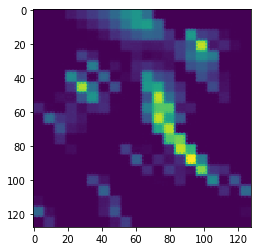

In [34]:
plt.imshow(label[10])

In [35]:
def bicubic_interpolate(image,shape):
    img_resized=cv2.resize(image,shape, interpolation=cv2.INTER_CUBIC)
    return img_resized

In [36]:
def residual_block_gen(ch=64,k_s=3,st=1):
    model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
      ])
    return model

def Upsample_block(x, ch=256, k_s=3, st=1):
    x = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st), padding='same')(x)
    x = tf.nn.depth_to_space(x, 2) # Subpixel pixelshuffler
    x = tf.keras.layers.LeakyReLU()(x)
    return x

input_lr=tf.keras.layers.Input(shape=(None,None,1))
input_conv=tf.keras.layers.Conv2D(64,9,padding='same')(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

SRRes = input_conv

for x in range(5):
    res_output=residual_block_gen()(SRRes)
    SRRes=tf.keras.layers.Add()([SRRes,res_output])

SRRes=tf.keras.layers.Conv2D(64,9,padding='same')(SRRes)
SRRes=tf.keras.layers.BatchNormalization()(SRRes)

SRRes=tf.keras.layers.Add()([SRRes,input_conv])

for i in range(scale//2):
    SRRes=Upsample_block(SRRes)
# SRRes=Upsample_block(SRRes)

output_sr=tf.keras.layers.Conv2D(1,9,activation='tanh',padding='same')(SRRes)

SRResnet=tf.keras.models.Model(input_lr,output_sr)

In [37]:
SRResnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, None, None, 6 5248        input_5[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_33 (LeakyReLU)      (None, None, None, 6 0           conv2d_36[0][0]                  
__________________________________________________________________________________________________
sequential_17 (Sequential)      (None, None, None, 6 74368       leaky_re_lu_33[0][0]             
____________________________________________________________________________________________

In [38]:
def residual_block_disc(ch=64,k_s=3,st=1):
    model=tf.keras.Sequential([
        tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
      ])
    return model

input_lr=tf.keras.layers.Input(shape=(128, 128,1))
input_conv=tf.keras.layers.Conv2D(64,3,padding='same', input_shape=(None,None,1))(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

channel_nums=[64,128,128,256,256,512,512]
stride_sizes=[2,1,2,1,2,1,2]

disc=input_conv

for x in range(7):
    disc=residual_block_disc(ch=channel_nums[x],st=stride_sizes[x])(disc)

disc=tf.keras.layers.Flatten()(disc)

disc=tf.keras.layers.Dense(1024)(disc)
disc=tf.keras.layers.LeakyReLU()(disc)

disc_output=tf.keras.layers.Dense(1,activation='sigmoid')(disc)

discriminator=tf.keras.models.Model(input_lr,disc_output)

In [39]:
discriminator.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   (None, 128, 128, 64)      0         
_________________________________________________________________
sequential_22 (Sequential)   (None, 64, 64, 64)        37184     
_________________________________________________________________
sequential_23 (Sequential)   (None, 64, 64, 128)       74368     
_________________________________________________________________
sequential_24 (Sequential)   (None, 32, 32, 128)       148096    
_________________________________________________________________
sequential_25 (Sequential)   (None, 32, 32, 256)       2961

In [40]:
def PSNR(y_true,y_pred):
    mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
    return 20 * log10(1 / (mse ** 0.5))

def log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator

def pixel_MSE(y_true,y_pred):
    return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [41]:
VGG19=tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=(128, 128,3))

VGG_i,VGG_j=2,2

def VGG_loss(y_hr,y_sr,i_m=2,j_m=2):
    i,j=0,0
    accumulated_loss=0.0
    for l in VGG19.layers:
        cl_name=l.__class__.__name__
        if cl_name=='Conv2D':
            j+=1
        if cl_name=='MaxPooling2D':
            i+=1
            j=0
        if i==i_m and j==j_m:
            break

    y_hr=l(y_hr)
    y_sr=l(y_sr)
    if cl_name=='Conv2D':
        accumulated_loss+=tf.reduce_mean((y_hr-y_sr)**2) * 0.006

    return accumulated_loss


def VGG_loss_intuitive(y_true,y_pred):
    accumulated_loss=0.0
    for l in VGG19.layers:
        y_true=l(y_true)
        y_pred=l(y_pred)
        accumulated_loss+=tf.reduce_mean((y_true-y_pred)**2) * 0.006
    return accumulated_loss

In [42]:
generator_optimizer=tf.keras.optimizers.SGD(0.0001)
discriminator_optimizer=tf.keras.optimizers.SGD(0.0001)

adv_ratio=0.001
evaluate=['PSNR']
# MSE
loss_func,adv_learning = pixel_MSE,False
# VGG2.2
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=2,j_m=2),False
# VGG 5.4
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),False
# SRGAN-MSE
loss_func,adv_learning = pixel_MSE,True
# SRGAN-VGG 2.2
# loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=2,j_m=2),True
# # SRGAN-VGG 5.4
# loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),True

# #Real loss
# loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),True

In [43]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function()
def train_step(lr_data, hr_data,loss_func=pixel_MSE,adv_learning=True,evaluate=['PSNR'],adv_ratio=0.1):
    logs = {}
    gen_loss,disc_loss=0,0

    low_resolution, high_resolution = lr_data, hr_data

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        super_resolution = SRResnet(low_resolution, training=True)
        gen_loss=loss_func(high_resolution,super_resolution)

        logs['reconstruction']=gen_loss
        
        if adv_learning:
            real_output = discriminator(high_resolution, training=True)
            fake_output = discriminator(super_resolution, training=True)

            adv_loss_g = generator_loss(fake_output) * adv_ratio
            gen_loss += adv_loss_g

            disc_loss = discriminator_loss(real_output, fake_output)
            logs['adv_g']=adv_loss_g
            logs['adv_d']=disc_loss


    gradients_of_generator = gen_tape.gradient(gen_loss, SRResnet.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, SRResnet.trainable_variables))

    if adv_learning:
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    for x in evaluate:
        if x=='PSNR':
            logs[x]=PSNR(high_resolution,super_resolution)

    return logs

In [44]:
data.shape

(120, 64, 64)

In [45]:
for x in range(1):
    lr_data, hr_data = data, label 
    for lr, hr in tqdm.tqdm(zip(data, label)):
        lr = tf.expand_dims(lr, axis=-1)
        lr = np.reshape(lr, (1,64,64,1))
        print(lr.shape)
        hr = tf.expand_dims(hr, axis=-1)
        hr = np.reshape(hr, (1,128,128,1))
        print(hr.shape)

        logs=train_step(lr,hr,loss_func,adv_learning,evaluate,adv_ratio)
        for k in logs.keys():
            print(k,':',logs[k],end='  ')
    print()

0it [00:00, ?it/s]

(1, 64, 64, 1)
(1, 128, 128, 1)


5it [04:30, 40.30s/it] 

reconstruction : tf.Tensor(0.014481883, shape=(), dtype=float32)  adv_g : tf.Tensor(0.00057695556, shape=(), dtype=float32)  adv_d : tf.Tensor(1.0465224, shape=(), dtype=float32)  PSNR : tf.Tensor(18.39175, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(

13it [04:30, 10.21s/it]

tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tens

21it [04:30,  4.06s/it]

tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tens

29it [04:31,  1.83s/it]

tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tens

37it [04:31,  1.14it/s]

tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tens

45it [04:31,  2.30it/s]

tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tens

53it [04:31,  4.46it/s]

tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tens

61it [04:31,  8.17it/s]

tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tens

69it [04:32, 13.70it/s]

tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tens

77it [04:32, 20.47it/s]

tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tens

85it [04:32, 26.98it/s]

tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tens

93it [04:32, 32.01it/s]

tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tens

101it [04:33, 35.15it/s]

tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tens

109it [04:33, 36.94it/s]

tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tens

120it [04:33,  2.28s/it]

tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tensor(nan, shape=(), dtype=float32)  adv_d : tf.Tensor(nan, shape=(), dtype=float32)  PSNR : tf.Tensor(nan, shape=(), dtype=float32)  (1, 64, 64, 1)
(1, 128, 128, 1)
reconstruction : tf.Tensor(nan, shape=(), dtype=float32)  adv_g : tf.Tens

In [17]:
h, w,c = data[0].shape

In [18]:
data[0].reshape(1, h,w,c).shape

(1, 64, 64, 3)

In [19]:
pred=SRResnet(data[0].reshape(1, h,w,c))
pred.shape

TensorShape([1, 128, 128, 3])

In [20]:

pred

<tf.Tensor: shape=(1, 128, 128, 3), dtype=float32, numpy=
array([[[[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        ...,

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan],
         ...,
         [nan, nan, nan],
         [nan, nan, nan],
         [nan, nan, nan]],

        [[nan, nan, nan],
         [nan, nan, nan],
         [nan, n

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(pred[0])